# Sistema Avaliação de Lances

- Carregar dados de vinho e separar vinhos tinto e branco: tintos para desenvolvimento/operação e vinhos brancos para novidade 
- Treinamento de modelo com regressão logística do sklearn no pyCaret
- Registros das etapas de processamento como runs
- Registro do modelo com threshold de precisão mínimo de 70% em Staging
- Aplicação Online: recomendação de vinhos
    - Consumo da base de dados de operação
    - Utilização do requests para fazer o POST e recuperar a predição do modelo
    - Propor os 5 vinhos de alta qualidade de maior nível alcólico (print data frame)
- Aplicação de Monitoramento: pipeline de monitoramento
    - Revalidacao da base de operacao para amostras de controle (simulação especialista)
    - Leitura da base de desenvolvimento (treino+teste)
    - Alarme de amostra de controle
    - Alarme com amostras de novidade
    
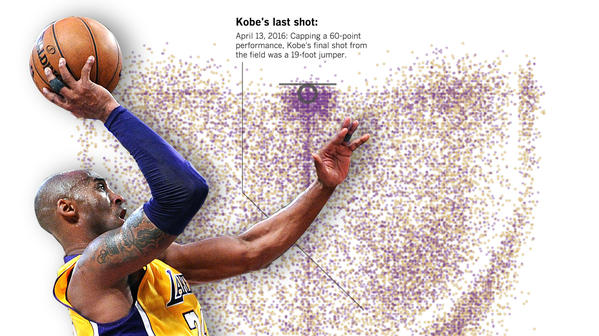


# Instalação e Importação das Bibliotecas envolvida

In [1]:
#!pip install mlflow
#!pip install pyarrow --user
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install pycaret --user
#!pip install sklearn --user 

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
if 'inline_rc' not in dir():
    inline_rc = dict(mpl.rcParams)
import numpy as np
from sklearn import metrics, model_selection
from sklearn.metrics import log_loss
import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
import seaborn as sn
import pycaret.classification as pc

SEED = 10
np.random.seed(SEED)

# Reset do estilo de cores do matplotlib 

In [3]:
mpl.rcParams.update(inline_rc)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
mpl.rc('font', **font)
lines = {'linewidth' : 3}
mpl.rc('lines', **lines)

# Preparação do ambiente Pycaret e MLFlow

In [4]:
# Para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Projeto Kobe'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id


In [5]:
# Para monitorar o MLFlow execute a linha abaixo a partir do Anaconda Prompt (ambiente local)
#mlflow ui --backend-store-uri sqlite:///mlruns.db

# Leitura e Preparação dos Dados

In [20]:
fname = '../Data/dataset_kobe.csv'
data = pd.read_csv(fname,sep=',')
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


Quais estratégias ajudam a minimizar os efeitos de viés de dados: Sobre Overfit. Estratégias: Validação Cruzada,

In [23]:
# COLOCAR RUN DE Preparação de Dados
# PARAMETROS: top_features,
# METRICS: SHAPE de cada base de dados
# ARTIFACTS: nenhum

#mlflow.start_run(experiment_id=experiment_id, run_name = 'PreparacaoDados')
top_features = ['lat','lon','minutes_remaining','period','playoffs','shot_distance']
target_col = 'shot_made_flag'

# Base de kobes para uso futuro como monitoramento
data_novelty = data[data['shot_type'] != '2PT Field Goal']
data_novelty = data_novelty[top_features + [target_col] + ['shot_type']]

# Filtra somente linhas com shot_type = '2PT Field Goal'
data = data[data.shot_type == '2PT Field Goal']

# Dropa somente onde houver NA nas colunas uteis, para isso salva-se nova versão do dataframe
data = data[top_features + [target_col]]
print(f'Linhas antes do drop {data.shape}')
data = data.dropna()
print(f'Linhas depois do drop {data.shape}')

# Salvando dados
data.to_parquet('../Data/processed/data_filtered.parquet')    
data_novelty.to_parquet('../Data/processed/data_novelty.parquet')   

# Separar Treino e Teste 
test_size = 0.2
(xtrain, xtest, 
ytrain, ytest) = model_selection.train_test_split(data[top_features], 
                                                  data[target_col],
                                                  test_size=test_size)
#                                                  stratify=data[target_col])
xtrain[target_col] = ytrain
xtest[target_col] = ytest
    
# LOG DE PARAMETROS DO MODELO
mlflow.log_param('test size', test_size)
mlflow.log_param("top features", top_features)
mlflow.log_param("target col", target_col)

# LOG DE METRICAS GLOBAIS
mlflow.log_metric('test shape', ytest.shape[0])
mlflow.log_metric("train shape", xtrain.shape[0])
mlflow.log_metric("novelty shape", data_novelty.shape[0])  
    
mlflow.end_run()       

Linhas antes do drop (24271, 7)
Linhas depois do drop (20285, 7)


# Treinamento do Modelo

In [11]:
# COLOCAR RUN DE TREINAMENTO DE MODELOS
# PARAMETROS: fold_strategy, fold, model_name, registered_model_name, cross_validation
# METRICS: auto sklearn
# ARTIFACTS: plots

#mlflow.start_run(experiment_id=experiment_id, run_name = 'TreinamentoModelo')

cls_exp = pc.setup(
    data = xtrain, 
    target = target_col,
    test_data = xtest,
    normalize = True,
    fold_strategy = 'stratifiedkfold',
    fold = 10,
    fold_shuffle = True,
    log_experiment = True, 
    experiment_name = experiment_name,
    silent = True
)
pc.add_metric('logloss', 'Log Loss', log_loss, greate_is_better = False)
models_names = ['lr', 'dt']
#models = pc.compare_models(include = models_names, sort='logloss', n_select=2)
models = pc.compare_models(include = models_names, n_select=2)

#mlflow.end_run()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss,TT (Sec)
lr,Logistic Regression,0.5831,0.6012,0.4965,0.5740,0.5323,0.1598,0.1612,0.0000,5.4370
dt,Decision Tree Classifier,0.5417,0.5200,0.5885,0.5181,0.5510,0.0868,0.0876,0.0000,0.0670


In [12]:
#Comparando Modelo

#mlflow.start_run(experiment_id=experiment_id, run_name = 'ComparacaoModelo')

classification_plots = [ 'auc','pr','confusion_matrix',
#                          'error', 'class_report', 
                        'threshold', 'learning','vc','feature']

best_model = models[0]
logloss_ant = 0

# Salvando métrica e artefatos dos modelos
for x in [0, 1]:
    model = models[x]
    pred = pc.predict_model(model, xtest)
    pred['Label'] = pred['Label'].astype(float)
    logloss = log_loss(ytest, pred['Label'])
    if logloss > logloss_ant:
        best_model = model
        loglossant = logloss
    mlflow.log_metric(f'Modelo {models_names[x]} - Log Loss', logloss)
    mlflow.log_metric(f'Modelo {models_names[x]} - F1 score', metrics.f1_score(ytest, pred['Label']))

    # Log do run, e nao do modelo respectivo
    for plot_type in classification_plots:
        print(f'{models_names[x]}=> Aplicando plot ', plot_type)
        try:
            artifact = pc.plot_model(model, plot=plot_type, save=True, use_train_data=False)
            mlflow.log_artifact(artifact)
        except:
            print('=> Nao possivel plotar: ', plot_type )
            continue

# Salvando e Registrando Modelo

In [14]:
registered_model_name = 'modelo_kobe'
model_version = -1 # recuperar a ultima versao
nexamples = 4
            
# Pycaret exporta o pipeline de transformação e o modelo
pc.save_model(best_model, f'./{registered_model_name}') 

# Carrega novamente o pipeline + bestmodel
model_pipe = pc.load_model(f'./{registered_model_name}')

# Assinatura do Modelo Inferida pelo MLFlow
model_features = list(data.drop(target_col, axis=1).columns)
inf_signature = infer_signature(data[model_features], model_pipe.predict(data))

# Exemplo de entrada para o MLmodel
input_example = {x: data[x].values[:nexamples] for x in model_features}
    
# Log do pipeline de modelagem do sklearn e registrar como uma nova versao
mlflow.sklearn.log_model(
       sk_model=model_pipe,
       artifact_path="sklearn-model",
       registered_model_name=registered_model_name,
       signature = inf_signature,
       input_example = input_example)

# Criacao do cliente do servico MLFlow e atualizacao versao modelo
client = MlflowClient()
if model_version == -1:
   model_version = client.get_latest_versions(registered_model_name)[-1].version

# Registrar o modelo como staging
client.transition_model_version_stage(name=registered_model_name,
        version=model_version, # Verificar com usuario qual versao
        stage="Staging")

# LOG DE METRICAS GLOBAIS
mlflow.log_metric("new_version", model_version)

#mlflow.end_run()

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


2022/09/12 22:24:55 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Edgar\AppData\Local\Temp\tmpzxykpbvg\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==0.23.2', 'cloudpickle==2.1.0']. Set logging level to DEBUG to see the full traceback.
Registered model 'modelo_kobe' already exists. Creating a new version of this model...
2022/09/12 22:24:55 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: modelo_kobe, version 3
Created version '3' of model 'modelo_kobe'.


# Serviço do Modelo 

In [15]:
os.environ['MLFLOW_TRACKING_URI'] = 'sqlite:///mlruns.db'
!mlflow models serve -m "models:/modelo_kobe/Staging" --no-conda -p 5001

^C


# Operação Sistema de Classificação de Jogadas

In [24]:
import requests
host = 'localhost'
port = '5001'
url = f'http://{host}:{port}/invocations'
headers = {'Content-Type': 'application/json',}

http_data = data_novelty.drop(target_col,axis=1).to_json(orient='split')
r = requests.post(url=url, headers=headers, data=http_data)

data_novelty.loc[:, 'operation_label'] = pd.read_json(r.text).values[:,0]

data_novelty.to_parquet('modelo_kobe_operacao.parquet')
data_novelty[data_novelty.operation_label == 1].sort_values('shot_made_flag', ascending=False).head(5)

,lat,lon,minutes_remaining,period,playoffs,shot_distance,shot_made_flag,shot_type,operation_label
19468,33.8603,-118.0888,1,1,0,25,1.0,3PT Field Goal,1
16173,34.0653,-118.4938,0,4,0,22,1.0,3PT Field Goal,1
21194,33.8173,-118.3788,1,4,0,25,1.0,3PT Field Goal,1
9359,33.8633,-118.0878,8,3,0,25,1.0,3PT Field Goal,1
16250,33.8023,-118.3298,5,3,0,24,1.0,3PT Field Goal,1


# Revalidacao de Amostras para Monitoramento

In [25]:
data_control.columns

NameError: name 'data_control' is not defined

In [ ]:
# COLOCAR RUN REVALIDACAO
# PARAMETROS: min_samples_control
# METRICS: matriz de confusao
# ARTIFACTS:


# Utilizacao da amostra de controle, que teria sido reavaliada por especialistas
min_samples_control = 150

with mlflow.start_run(experiment_id=experiment_id, run_name = 'RevalidacaoOperacao'):

    data_operation = pd.read_parquet('modelo_vinho_operacao.parquet')

    data_control = data_operation.sample(min_samples_control, random_state=SEED)
    data_control.to_parquet('modelo_vinho_controle.parquet')

    print('== DADOS DE CONTROLE ==')
    print(metrics.classification_report(data_control[wine_target_col], data_control['operation_label']))
    
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("min_samples_control", min_samples_control)

    # LOG DE METRICAS GLOBAIS
    cm = metrics.confusion_matrix(data_control[wine_target_col], data_control['operation_label'])
    specificity = cm[0,0] / cm.sum(axis=1)[0]
    sensibility = cm[1,1] / cm.sum(axis=1)[1]
    precision   = cm[1,1] / cm.sum(axis=0)[1]
    mlflow.log_metric("Especificidade", specificity)
    mlflow.log_metric("Sensibilidade", sensibility)
    mlflow.log_metric("Precisao", precision)

mlflow.end_run()

## Alarme de Desvio 

In [ ]:
# reset matplotlib

mpl.rcParams.update(inline_rc)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
mpl.rc('font', **font)
lines = {'linewidth' : 3}
mpl.rc('lines', **lines)

def data_drift_alarm(var_name, dev_data, data_test, data_control):    
    sn.kdeplot(dev_data[var_name], label='Desenvolvimento')
    sn.kdeplot(data_test[var_name], label='Teste')
    sn.kdeplot(data_control[var_name], label='Monitoramento')
    plt.grid()
    plt.legend(loc='best')
    plt.title(f'Distribuição Variável {var_name}')
    plt.ylabel('Densidade')
    plt.xlabel(f'Unidade de {var_name}')
    plt.tight_layout()

## Alarme de Retreinamento

In [ ]:
def alarm(data_monitoring, testset, min_eff_alarm):
    cm = metrics.confusion_matrix(data_monitoring[wine_target_col], data_monitoring['operation_label'])
    specificity_m = cm[0,0] / cm.sum(axis=1)[0]
    sensibility_m = cm[1,1] / cm.sum(axis=1)[1]
    precision_m   = cm[1,1] / cm.sum(axis=0)[1]

    cm = metrics.confusion_matrix(testset[wine_target_col], testset['Label'])
    specificity_t = cm[0,0] / cm.sum(axis=1)[0]
    sensibility_t = cm[1,1] / cm.sum(axis=1)[1]
    precision_t   = cm[1,1] / cm.sum(axis=0)[1]

    retrain = False
    for name, metric_m, metric_t in zip(['especificidade', 'sensibilidade', 'precisao'],
                                        [specificity_m, sensibility_m, precision_m],
                                        [specificity_t, sensibility_t, precision_t]):
        
        print(f'\t=> {name} de teste {metric_t} e de controle {metric_m}')
        if (metric_t-metric_m)/metric_t > min_eff_alarm:
            print(f'\t=> MODELO OPERANDO FORA DO ESPERADO')
            retrain = True
        else:
            print(f'\t=> MODELO OPERANDO DENTRO DO ESPERADO')
           
        
    return (retrain, [specificity_m, sensibility_m, precision_m],
                                        [specificity_t, sensibility_t, precision_t] ) 

### Monitoramento Base Operacao 

In [ ]:
# COLOCAR RUN MONITORAMENTO OPERACAO
# PARAMETROS: min_eff_alarm
# METRICS: metricas avaliadas e de referencia
# ARTIFACTS:

print('== ALARME DE RETREINAMENTO - BASE CONTROLE ==')
# 10% de desvio aceitavel na metrica. Deve ser estimado pelo conjunto de validacao cruzada. 
min_eff_alarm = 0.1 

with mlflow.start_run(experiment_id=experiment_id, run_name = 'MonitoramentoOperacao'):
    data_control = pd.read_parquet('modelo_vinho_controle.parquet')
    
    (retrain, [specificity_m, sensibility_m, precision_m],
              [specificity_t, sensibility_t, precision_t] ) = alarm(data_control, pred_holdout, min_eff_alarm)
    if retrain:
        print('==> RETREINAMENTO NECESSARIO')
    else:
        print('==> RETREINAMENTO NAO NECESSARIO')
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("min_eff_alarm", min_eff_alarm)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("Alarme Retreino", float(retrain))
    mlflow.log_metric("Especificidade Controle", specificity_m)
    mlflow.log_metric("Sensibilidade Controle", sensibility_m)
    mlflow.log_metric("Precisao Controle", precision_m)
    mlflow.log_metric("Especificidade Teste", specificity_t)
    mlflow.log_metric("Sensibilidade Teste", sensibility_t)
    mlflow.log_metric("Precisao Teste", precision_t)
    
    # LOG ARTEFATO
    var_name = 'volatile acidity' # 'alcohol'
    data_drift_alarm(var_name, data_wine, pred_holdout, data_control)
    plot_path = f'monitor_datadrift_{var_name}.png'
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)
    

mlflow.end_run()  

# Operação Aplicação Python 

### Monitoramento Base de Novidade

In [ ]:
# COLOCAR RUN MONITORAMENTO NOVIDADE
# PARAMETROS: min_eff_alarm
# METRICS: metricas avaliadas e de referencia
# ARTIFACTS:

print('== ALARME DE RETREINAMENTO - BASE NOVIDADE ==')
# 10% de desvio aceitavel na metrica. Deve ser estimado pelo conjunto de validacao cruzada. 
min_eff_alarm = 0.1 

with mlflow.start_run(experiment_id=experiment_id, run_name = 'MonitoramentoNovidade'):

    model_uri = f"models:/modelo_vinho_tinto/Staging"
    loaded_model = mlflow.sklearn.load_model(model_uri)
    data_novelty = pd.read_parquet('modelo_vinho_novidade.parquet')
    data_novelty.loc[:, 'operation_label'] = loaded_model.predict(data_novelty.drop(wine_target_col,axis=1))
    
    (retrain, [specificity_m, sensibility_m, precision_m],
              [specificity_t, sensibility_t, precision_t] ) = alarm(data_novelty, pred_holdout, min_eff_alarm)
    if retrain:
        print('==> RETREINAMENTO NECESSARIO')
    else:
        print('==> RETREINAMENTO NAO NECESSARIO')
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("min_eff_alarm", min_eff_alarm)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("Alarme Retreino", float(retrain))
    mlflow.log_metric("Especificidade Controle", specificity_m)
    mlflow.log_metric("Sensibilidade Controle", sensibility_m)
    mlflow.log_metric("Precisao Controle", precision_m)
    mlflow.log_metric("Especificidade Teste", specificity_t)
    mlflow.log_metric("Sensibilidade Teste", sensibility_t)
    mlflow.log_metric("Precisao Teste", precision_t)
    # LOG ARTEFATO
    var_name = 'volatile acidity' # 'alcohol'
    data_drift_alarm(var_name, data_wine, pred_holdout, data_novelty)
    plot_path = f'novidade_datadrift_{var_name}.png'
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)

mlflow.end_run()  